In [6]:
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

DATA_DIR = Path("../data")
PROCESSED_DIR = DATA_DIR / "processed"
ART = Path("../artifacts"); ART.mkdir(parents=True, exist_ok=True)
OOF_DIR = ART / "oof"; OOF_DIR.mkdir(exist_ok=True)
SUB_DIR = ART / "submissions"; SUB_DIR.mkdir(exist_ok=True)

train_path = PROCESSED_DIR / "hp_train_feat_v04.csv"
test_path  = PROCESSED_DIR / "hp_test_feat_v04.csv"
folds_path = PROCESSED_DIR / "cv_folds_strat_nbhd_price_v01.csv"

df_tr = pd.read_csv(train_path)
df_te = pd.read_csv(test_path)
folds = pd.read_csv(folds_path)
df_tr = df_tr.merge(folds, on="Id", how="left")

y_log = np.log1p(df_tr["SalePrice"]).astype(float)

drop_cols = ["Id","SalePrice","fold"]
X = df_tr.drop(columns=drop_cols)
X_te = df_te.drop(columns=["Id"])

# identify column types
cat_cols = [c for c in X.columns if (X[c].dtype == "object") or c.endswith("_cat_v4")]
num_cols = [c for c in X.columns if c not in cat_cols]

fold = df_tr["fold"].values

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import clone

# For linear models: numeric scaled (keep sparse), categoricals → OHE (sparse)
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
pre_linear = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", ohe, cat_cols),
    ],
    remainder="drop",
    sparse_threshold=1.0,
)

# For KernelRidge: numeric-only, dense scaler
pre_krr = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=True), num_cols),
    ],
    remainder="drop",
    sparse_threshold=0.0,
)

In [8]:
from sklearn.linear_model import RidgeCV
ridge_alphas = np.logspace(-3, 3, 25)

oof_ridge = np.zeros(len(X), dtype=float)
ridge_models, ridge_fold_rmse = [], []

for k in sorted(np.unique(fold)):
    tr_idx = np.where(fold != k)[0]
    va_idx = np.where(fold == k)[0]

    pipe = Pipeline([
        ("prep", clone(pre_linear)),  # <-- clone here
        ("model", RidgeCV(alphas=ridge_alphas, cv=5, fit_intercept=True))
    ])
    pipe.fit(X.iloc[tr_idx], y_log.iloc[tr_idx])
    pred_va = pipe.predict(X.iloc[va_idx])

    oof_ridge[va_idx] = pred_va
    ridge_fold_rmse.append(float(np.sqrt(mean_squared_error(y_log.iloc[va_idx], pred_va))))
    ridge_models.append(pipe)

# test preds: average over fold models
ridge_test_pred = np.column_stack([m.predict(X_te) for m in ridge_models]).mean(axis=1)
ridge_sub = pd.DataFrame({"Id": df_te["Id"], "SalePrice": np.expm1(ridge_test_pred)})
ridge_oof = pd.DataFrame({"Id": df_tr["Id"], "pred_log": oof_ridge})

ridge_oof.to_csv(OOF_DIR / "ridge_v04_nbhdstrat_oof.csv", index=False)
ridge_sub.to_csv(SUB_DIR / "ridge_v04_nbhdstrat.csv", index=False)

pd.DataFrame({"model":["Ridge_v04_nbhdstrat"], 
              "cv_rmse_mean_log":[float(np.mean(ridge_fold_rmse))], 
              "cv_rmse_std_log":[float(np.std(ridge_fold_rmse))]})

,model,cv_rmse_mean_log,cv_rmse_std_log
0,Ridge_v04_nbhdstrat,0.111102,0.008858


In [10]:
from sklearn.linear_model import LassoCV

lasso_alphas = np.logspace(-4, 2, 40)

oof_lasso = np.zeros(len(X), dtype=float)
lasso_models = []
lasso_fold_rmse = []

for k in sorted(np.unique(fold)):
    tr_idx = np.where(fold != k)[0]
    va_idx = np.where(fold == k)[0]

    pipe = Pipeline([
        ("prep", clone(pre_linear)),
        ("model", LassoCV(alphas=lasso_alphas, cv=5, max_iter=20000, n_jobs=-1, random_state=42))
    ])
    pipe.fit(X.iloc[tr_idx], y_log.iloc[tr_idx])
    pred_va = pipe.predict(X.iloc[va_idx])
    oof_lasso[va_idx] = pred_va
    lasso_fold_rmse.append(float(np.sqrt(mean_squared_error(y_log.iloc[va_idx], pred_va))))
    lasso_models.append(pipe)

lasso_cv_mean = float(np.mean(lasso_fold_rmse))
lasso_cv_std  = float(np.std(lasso_fold_rmse))

lasso_test_pred = np.column_stack([m.predict(X_te) for m in lasso_models]).mean(axis=1)
lasso_sub = pd.DataFrame({"Id": df_te["Id"], "SalePrice": np.expm1(lasso_test_pred)})
lasso_oof = pd.DataFrame({"Id": df_tr["Id"], "pred_log": oof_lasso})

lasso_oof.to_csv(OOF_DIR / "lasso_v04_nbhdstrat_oof.csv", index=False)
lasso_sub.to_csv(SUB_DIR / "lasso_v04_nbhdstrat.csv", index=False)

pd.DataFrame({"model":["Lasso_v04_nbhdstrat"], "cv_rmse_mean_log":[lasso_cv_mean], "cv_rmse_std_log":[lasso_cv_std]})

,model,cv_rmse_mean_log,cv_rmse_std_log
0,Lasso_v04_nbhdstrat,0.109736,0.007192


In [11]:
from sklearn.linear_model import ElasticNetCV

enet_alphas = np.logspace(-4, 2, 40)
enet_l1 = [0.1, 0.3, 0.5, 0.7, 0.9]

oof_enet = np.zeros(len(X), dtype=float)
enet_models = []
enet_fold_rmse = []

for k in sorted(np.unique(fold)):
    tr_idx = np.where(fold != k)[0]
    va_idx = np.where(fold == k)[0]

    pipe = Pipeline([
        ("prep", clone(pre_linear)),
        ("model", ElasticNetCV(l1_ratio=enet_l1, alphas=enet_alphas, cv=5, max_iter=20000, n_jobs=-1, random_state=42))
    ])
    pipe.fit(X.iloc[tr_idx], y_log.iloc[tr_idx])
    pred_va = pipe.predict(X.iloc[va_idx])
    oof_enet[va_idx] = pred_va
    enet_fold_rmse.append(float(np.sqrt(mean_squared_error(y_log.iloc[va_idx], pred_va))))
    enet_models.append(pipe)

enet_cv_mean = float(np.mean(enet_fold_rmse))
enet_cv_std  = float(np.std(enet_fold_rmse))

enet_test_pred = np.column_stack([m.predict(X_te) for m in enet_models]).mean(axis=1)
enet_sub = pd.DataFrame({"Id": df_te["Id"], "SalePrice": np.expm1(enet_test_pred)})
enet_oof = pd.DataFrame({"Id": df_tr["Id"], "pred_log": oof_enet})

enet_oof.to_csv(OOF_DIR / "elasticnet_v04_nbhdstrat_oof.csv", index=False)
enet_sub.to_csv(SUB_DIR / "elasticnet_v04_nbhdstrat.csv", index=False)

pd.DataFrame({"model":["ElasticNet_v04_nbhdstrat"], "cv_rmse_mean_log":[enet_cv_mean], "cv_rmse_std_log":[enet_cv_std]})

,model,cv_rmse_mean_log,cv_rmse_std_log
0,ElasticNet_v04_nbhdstrat,0.109752,0.007334


In [12]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

# modest grid (fast for n~1460); tweak if you want
krr_param_grid = {
    "model__alpha":  np.logspace(-3, 2, 6),   # 1e-3 ... 1e2
    "model__gamma":  np.logspace(-3, 0, 4),   # 1e-3 ... 1
    "model__kernel": ["rbf"],
}

oof_krr = np.zeros(len(X), dtype=float)
krr_models = []
krr_fold_rmse = []

for k in sorted(np.unique(fold)):
    tr_idx = np.where(fold != k)[0]
    va_idx = np.where(fold == k)[0]

    pipe = Pipeline([
        ("prep", clone(pre_krr)),
        ("model", KernelRidge(kernel="rbf"))
    ])
    gscv = GridSearchCV(
        estimator=pipe,
        param_grid=krr_param_grid,
        scoring="neg_root_mean_squared_error",
        cv=5,
        n_jobs=-1
    )
    gscv.fit(X.iloc[tr_idx], y_log.iloc[tr_idx])

    best = gscv.best_estimator_
    pred_va = best.predict(X.iloc[va_idx])
    oof_krr[va_idx] = pred_va
    krr_fold_rmse.append(float(np.sqrt(mean_squared_error(y_log.iloc[va_idx], pred_va))))
    krr_models.append(best)

krr_cv_mean = float(np.mean(krr_fold_rmse))
krr_cv_std  = float(np.std(krr_fold_rmse))

krr_test_pred = np.column_stack([m.predict(X_te) for m in krr_models]).mean(axis=1)
krr_sub = pd.DataFrame({"Id": df_te["Id"], "SalePrice": np.expm1(krr_test_pred)})
krr_oof = pd.DataFrame({"Id": df_tr["Id"], "pred_log": oof_krr})

krr_oof.to_csv(OOF_DIR / "kernelridge_v04_nbhdstrat_oof.csv", index=False)
krr_sub.to_csv(SUB_DIR / "kernelridge_v04_nbhdstrat.csv", index=False)

pd.DataFrame({"model":["KernelRidge_v04_nbhdstrat"], "cv_rmse_mean_log":[krr_cv_mean], "cv_rmse_std_log":[krr_cv_std]})

,model,cv_rmse_mean_log,cv_rmse_std_log
0,KernelRidge_v04_nbhdstrat,0.270646,0.109632


In [13]:
# Load cat v04 oof, align, and inspect correlations
cat_oof_path = OOF_DIR / "cat_v04_baseline_oof.csv"
if cat_oof_path.exists():
    cat = pd.read_csv(cat_oof_path)[["Id","pred_log"]].rename(columns={"pred_log":"cat"})
    ridge = pd.read_csv(OOF_DIR / "ridge_v04_nbhdstrat_oof.csv").rename(columns={"pred_log":"ridge"})
    lasso = pd.read_csv(OOF_DIR / "lasso_v04_nbhdstrat_oof.csv").rename(columns={"pred_log":"lasso"})
    enet  = pd.read_csv(OOF_DIR / "elasticnet_v04_nbhdstrat_oof.csv").rename(columns={"pred_log":"elasticnet"})
    krr   = pd.read_csv(OOF_DIR / "kernelridge_v04_nbhdstrat_oof.csv").rename(columns={"pred_log":"kernelridge"})

    o = cat.merge(ridge,on="Id").merge(lasso,on="Id").merge(enet,on="Id").merge(krr,on="Id")
    o[[c for c in o.columns if c!="Id"]].corr().round(3)

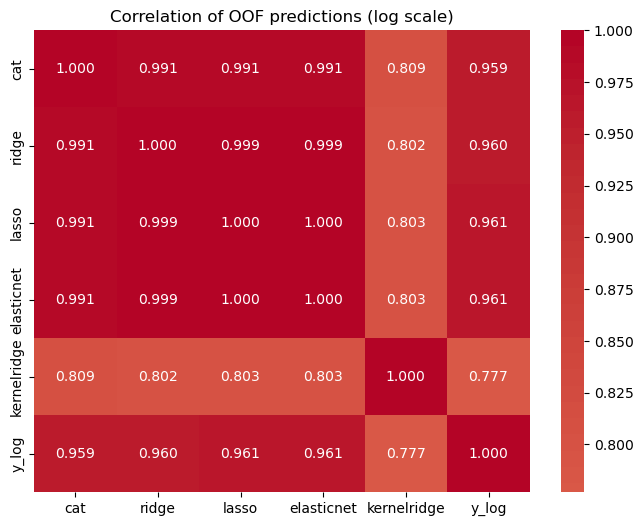

,cat,ridge,lasso,elasticnet,kernelridge,y_log
cat,1.000,0.991,0.991,0.991,0.809,0.959
ridge,0.991,1.000,0.999,0.999,0.802,0.960
lasso,0.991,0.999,1.000,1.000,0.803,0.961
elasticnet,0.991,0.999,1.000,1.000,0.803,0.961
kernelridge,0.809,0.802,0.803,0.803,1.000,0.777
y_log,0.959,0.960,0.961,0.961,0.777,1.000


In [15]:
# --- Load OOFs ---
cat   = pd.read_csv(OOF_DIR / "cat_v04_baseline_oof.csv")[["Id","pred_log"]].rename(columns={"pred_log":"cat"})
ridge = pd.read_csv(OOF_DIR / "ridge_v04_nbhdstrat_oof.csv").rename(columns={"pred_log":"ridge"})
lasso = pd.read_csv(OOF_DIR / "lasso_v04_nbhdstrat_oof.csv").rename(columns={"pred_log":"lasso"})
enet  = pd.read_csv(OOF_DIR / "elasticnet_v04_nbhdstrat_oof.csv").rename(columns={"pred_log":"elasticnet"})
krr   = pd.read_csv(OOF_DIR / "kernelridge_v04_nbhdstrat_oof.csv").rename(columns={"pred_log":"kernelridge"})

# --- Merge with target ---
o = df_tr[["Id"]].merge(cat,on="Id").merge(ridge,on="Id").merge(lasso,on="Id").merge(enet,on="Id").merge(krr,on="Id")
o["y_log"] = y_log.values

# --- Correlation matrix ---
corr = o.drop(columns=["Id"]).corr().round(3)

# --- Display ---
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".3f", cmap="coolwarm", center=0)
plt.title("Correlation of OOF predictions (log scale)")
plt.show()

corr

In [16]:
# --- Collect CV results ---
results = []

# CatBoost (from its OOF file, you may have logged CV mean/std separately too)
cat_rmse_mean = o["cat"].sub(o["y_log"]).pow(2).mean()**0.5   # quick recompute if you didn’t save
cat_rmse_std  = o.groupby(df_tr["fold"]).apply(lambda g: ((g["cat"]-g["y_log"])**2).mean()**0.5).std()
results.append({"model":"CatBoost_v04", "cv_rmse_mean_log":cat_rmse_mean, "cv_rmse_std_log":cat_rmse_std})

# Ridge
results.append({"model":"Ridge_v04_nbhdstrat", 
                "cv_rmse_mean_log":ridge_cv_mean, 
                "cv_rmse_std_log":ridge_cv_std})

# Lasso
results.append({"model":"Lasso_v04_nbhdstrat", 
                "cv_rmse_mean_log":lasso_cv_mean, 
                "cv_rmse_std_log":lasso_cv_std})

# ElasticNet
results.append({"model":"ElasticNet_v04_nbhdstrat", 
                "cv_rmse_mean_log":enet_cv_mean, 
                "cv_rmse_std_log":enet_cv_std})

# KernelRidge
results.append({"model":"KernelRidge_v04_nbhdstrat", 
                "cv_rmse_mean_log":krr_cv_mean, 
                "cv_rmse_std_log":krr_cv_std})

# --- Create summary DataFrame ---
cv_summary = pd.DataFrame(results)
cv_summary = cv_summary.sort_values("cv_rmse_mean_log").reset_index(drop=True)
cv_summary

,model,cv_rmse_mean_log,cv_rmse_std_log
0,Lasso_v04_nbhdstrat,0.109736,0.007192
1,ElasticNet_v04_nbhdstrat,0.109752,0.007334
2,Ridge_v04_nbhdstrat,0.111102,0.008858
3,CatBoost_v04,0.113372,0.009758
4,KernelRidge_v04_nbhdstrat,0.270646,0.109632


In [17]:
# Stacker: Ridge meta on OOF predictions (Cat + Ridge + Lasso + ElasticNet)
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

ART = Path("../artifacts")
OOF_DIR = ART / "oof"
SUB_DIR = ART / "submissions"

# Load base OOFs (log) and target
cat   = pd.read_csv(OOF_DIR / "cat_v04_baseline_oof.csv")[["Id","pred_log"]].rename(columns={"pred_log":"cat"})
ridge = pd.read_csv(OOF_DIR / "ridge_v04_nbhdstrat_oof.csv").rename(columns={"pred_log":"ridge"})
lasso = pd.read_csv(OOF_DIR / "lasso_v04_nbhdstrat_oof.csv").rename(columns={"pred_log":"lasso"})
enet  = pd.read_csv(OOF_DIR / "elasticnet_v04_nbhdstrat_oof.csv").rename(columns={"pred_log":"elasticnet"})

# Merge OOF features and y_log
X_meta_oof = cat.merge(ridge, on="Id").merge(lasso, on="Id").merge(enet, on="Id")
y_df = pd.read_csv("../data/processed/hp_train_feat_v04.csv", usecols=["Id","SalePrice"])
y_df["y_log"] = np.log1p(y_df["SalePrice"])
X_meta_oof = X_meta_oof.merge(y_df[["Id","y_log"]], on="Id", how="left")

# Load base TEST submissions to form meta test features (log space)
cat_sub   = pd.read_csv(SUB_DIR / "cat_v04_baseline.csv").sort_values("Id")
ridge_sub = pd.read_csv(SUB_DIR / "ridge_v04_nbhdstrat.csv").sort_values("Id")
lasso_sub = pd.read_csv(SUB_DIR / "lasso_v04_nbhdstrat.csv").sort_values("Id")
enet_sub  = pd.read_csv(SUB_DIR / "elasticnet_v04_nbhdstrat.csv").sort_values("Id")

X_meta_test = pd.DataFrame({
    "Id": cat_sub["Id"].values,
    "cat": np.log1p(cat_sub["SalePrice"].values),
    "ridge": np.log1p(ridge_sub["SalePrice"].values),
    "lasso": np.log1p(lasso_sub["SalePrice"].values),
    "elasticnet": np.log1p(enet_sub["SalePrice"].values),
})

# Folds for leak-free 2nd-level CV
folds = pd.read_csv("../data/processed/cv_folds_strat_nbhd_price_v01.csv")[["Id","fold"]]
X_meta_oof = X_meta_oof.merge(folds, on="Id", how="left")

feat_cols = ["cat","ridge","lasso","elasticnet"]
y = X_meta_oof["y_log"].values
fold = X_meta_oof["fold"].values

# Train meta (RidgeCV) fold-wise → OOF for stacker + averaged TEST
alphas = np.logspace(-6, 3, 40)
meta_oof = np.zeros(len(X_meta_oof))
test_fold_preds = []
fold_scores = []

for k in sorted(np.unique(fold)):
    tr_idx = np.where(fold != k)[0]
    va_idx = np.where(fold == k)[0]
    X_tr, y_tr = X_meta_oof.iloc[tr_idx][feat_cols].values, y[tr_idx]
    X_va, y_va = X_meta_oof.iloc[va_idx][feat_cols].values, y[va_idx]

    meta = RidgeCV(alphas=alphas, cv=5, fit_intercept=True)
    meta.fit(X_tr, y_tr)

    pred_va = meta.predict(X_va)
    meta_oof[va_idx] = pred_va
    fold_scores.append(float(np.sqrt(mean_squared_error(y_va, pred_va))))

    # predict on test meta features for this fold
    test_fold_preds.append(meta.predict(X_meta_test[feat_cols].values))

cv_rmse_mean_log = float(np.mean(fold_scores))
cv_rmse_std_log  = float(np.std(fold_scores))

pd.DataFrame({
    "metric": ["stack_cv_rmse_mean_log","stack_cv_rmse_std_log"] + [f"fold{i}_rmse_log" for i in range(len(fold_scores))],
    "value":  [cv_rmse_mean_log,         cv_rmse_std_log]        + fold_scores
})

,metric,value
0,stack_cv_rmse_mean_log,0.109984
1,stack_cv_rmse_std_log,0.007876
2,fold0_rmse_log,0.097336
3,fold1_rmse_log,0.112323
4,fold2_rmse_log,0.121251
5,fold3_rmse_log,0.112445
6,fold4_rmse_log,0.106564


In [18]:
# Save stacked OOF + submission
stack_oof = pd.DataFrame({"Id": X_meta_oof["Id"].values, "pred_log": meta_oof})
stack_test_log = np.column_stack(test_fold_preds).mean(axis=1)
stack_sub = pd.DataFrame({"Id": X_meta_test["Id"].values, "SalePrice": np.expm1(stack_test_log)})

tag = "stack_ridge_meta_cat_ridge_lasso_enet_v04_nbhdstrat"
stack_oof.to_csv(OOF_DIR / f"{tag}_oof.csv", index=False)
stack_sub.to_csv(SUB_DIR / f"{tag}.csv", index=False)

pd.Series({"oof_path": str(OOF_DIR / f"{tag}_oof.csv"),
           "submission_path": str(SUB_DIR / f"{tag}.csv")})

oof_path           ../artifacts/oof/stack_ridge_meta_cat_ridge_la...
submission_path    ../artifacts/submissions/stack_ridge_meta_cat_...
dtype: object

In [19]:
from pathlib import Path
import numpy as np, pandas as pd
from sklearn.metrics import mean_squared_error

ART = Path("../artifacts")
OOF_DIR = ART / "oof"
SUB_DIR = ART / "submissions"
DATA_DIR = Path("../data")
PROCESSED_DIR = DATA_DIR / "processed"

# Ground-truth for CV
df_tr = pd.read_csv(PROCESSED_DIR / "hp_train_feat_v04.csv", usecols=["Id","SalePrice"])
df_tr["y_log"] = np.log1p(df_tr["SalePrice"])

# Declare candidates (edit filenames here if needed)
candidates = {
    "cat": {
        "oof": OOF_DIR / "cat_v04_baseline_oof.csv",
        "sub": SUB_DIR / "cat_v04_baseline.csv",
        "oof_col": "pred_log", "sub_col": "SalePrice",
    },
    "xgb": {
        "oof": OOF_DIR / "xgb_v02_optuna_nbhdstrat_oof.csv",         # change if your xgb tag differs
        "sub": SUB_DIR / "xgb_v02_optuna_nbhdstrat.csv",
        "oof_col": "pred_log", "sub_col": "SalePrice",
    },
    "elasticnet": {
        "oof": OOF_DIR / "elasticnet_v04_nbhdstrat_oof.csv",
        "sub": SUB_DIR / "elasticnet_v04_nbhdstrat.csv",
        "oof_col": "pred_log", "sub_col": "SalePrice",
    },
}

# Keep only models whose files exist
models = {k:v for k,v in candidates.items() if v["oof"].exists() and v["sub"].exists()}

# Load OOFs merged with target
o = df_tr[["Id","y_log"]].copy()
for name, spec in models.items():
    dfm = pd.read_csv(spec["oof"])[["Id", spec["oof_col"]]].rename(columns={spec["oof_col"]: name})
    o = o.merge(dfm, on="Id", how="inner")

# Build OOF matrix (log) and target
feat_names = [k for k in models.keys()]
X_oof = o[feat_names].values
y_oof = o["y_log"].values

# Load TEST predictions (convert to log)
subs = {}
for name, spec in models.items():
    s = pd.read_csv(spec["sub"]).sort_values("Id")
    subs[name] = np.log1p(s[spec["sub_col"]].values)
test_ids = s["Id"].values  # last loaded; all are aligned by sort
X_test = np.column_stack([subs[name] for name in feat_names])
len(feat_names), feat_names

(3, ['cat', 'xgb', 'elasticnet'])

In [20]:
def simplex_grid(n_models, step=0.05):
    """Generate nonneg weight vectors of length n_models that sum to 1 at the given step."""
    if n_models == 1:
        yield np.array([1.0]); return
    if n_models == 2:
        w = np.arange(0.0, 1.0 + 1e-9, step)
        for a in w:
            yield np.array([a, 1.0 - a]); 
        return
    # n >= 3: recursive
    def rec(prefix, remaining, k):
        if k == 1:
            yield np.array(prefix + [remaining])
            return
        w = np.arange(0.0, remaining + 1e-9, step)
        for a in w:
            yield from rec(prefix + [a], remaining - a, k - 1)
    yield from rec([], 1.0, n_models)

# Search weights
records = []
for w in simplex_grid(len(feat_names), step=0.05):
    pred = X_oof @ w
    rmse = float(np.sqrt(mean_squared_error(y_oof, pred)))
    records.append({"weights": w, "cv_rmse_log": rmse})

grid_df = pd.DataFrame({
    "cv_rmse_log": [r["cv_rmse_log"] for r in records],
    **{f"w_{name}": [r["weights"][i] for r in records] for i, name in enumerate(feat_names)}
}).sort_values("cv_rmse_log").reset_index(drop=True)

# Best weights on OOF
best_w = grid_df.loc[0, [c for c in grid_df.columns if c.startswith("w_")]].to_numpy()
oof_blend = X_oof @ best_w
cv_best = float(np.sqrt(mean_squared_error(y_oof, oof_blend)))

# Build blended TEST preds and save
test_blend_log = X_test @ best_w
sub_blend = pd.DataFrame({"Id": test_ids, "SalePrice": np.expm1(test_blend_log)})

tag = f"blend_logspace_{'_'.join(feat_names)}"
# include weights in filename (e.g., cat0.6_xgb0.3_en0.1)
wtag = "_".join([f"{n}{best_w[i]:.2f}" for i,n in enumerate(feat_names)])
sub_path = SUB_DIR / f"{tag}_{wtag}.csv"
oof_path = OOF_DIR / f"{tag}_{wtag}_oof.csv"

pd.DataFrame({"Id": o["Id"].values, "pred_log": oof_blend}).to_csv(oof_path, index=False)
sub_blend.to_csv(sub_path, index=False)

grid_df.head(10), pd.Series({"best_cv_rmse_log": cv_best, "submission": str(sub_path), "oof": str(oof_path)})

(   cv_rmse_log  w_cat  w_xgb  w_elasticnet
 0     0.108200   0.20   0.20          0.60
 1     0.108210   0.25   0.15          0.60
 2     0.108222   0.15   0.25          0.60
 3     0.108229   0.20   0.15          0.65
 4     0.108229   0.25   0.20          0.55
 5     0.108232   0.15   0.20          0.65
 6     0.108238   0.20   0.25          0.55
 7     0.108252   0.30   0.10          0.60
 8     0.108252   0.30   0.15          0.55
 9     0.108258   0.25   0.10          0.65,
 best_cv_rmse_log                                               0.1082
 submission          ../artifacts/submissions/blend_logspace_cat_xg...
 oof                 ../artifacts/oof/blend_logspace_cat_xgb_elasti...
 dtype: object)

In [22]:
# Set your own weights (must match feat_names order and sum to 1)
manual_w = np.array([0.80, 0.10, 0.10])  # example for [cat, xgb, elasticnet]
manual_w = manual_w / manual_w.sum()

oof_blend_m = X_oof @ manual_w
cv_manual = float(np.sqrt(mean_squared_error(y_oof, oof_blend_m)))
test_blend_log_m = X_test @ manual_w

sub_manual = pd.DataFrame({"Id": test_ids, "SalePrice": np.expm1(test_blend_log_m)})
wtag_m = "_".join([f"{n}{manual_w[i]:.2f}" for i,n in enumerate(feat_names)])
sub_path_m = SUB_DIR / f"{tag}_MANUAL_{wtag_m}.csv"
oof_path_m = OOF_DIR / f"{tag}_MANUAL_{wtag_m}_oof.csv"

pd.DataFrame({"Id": o["Id"].values, "pred_log": oof_blend_m}).to_csv(oof_path_m, index=False)
sub_manual.to_csv(sub_path_m, index=False)

pd.DataFrame({"feat": feat_names, "weight": manual_w}), pd.Series({"cv_rmse_log_manual": cv_manual, "submission": str(sub_path_m)})

(         feat  weight
 0         cat     0.8
 1         xgb     0.1
 2  elasticnet     0.1,
 cv_rmse_log_manual                                             0.111542
 submission            ../artifacts/submissions/blend_logspace_cat_xg...
 dtype: object)